# User log clustering

In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/mariosk/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load and inspect the transaction data

In [2]:
user_logs = pd.read_csv('/home/mariosk/data/kkbox-churn/user_logs_v2.csv/data/churn_comp_refresh/user_logs_v2.csv').assign(date=lambda df: pd.to_datetime(df['date'], format='%Y%m%d'))
user_logs.shape

(18396362, 9)

## Pre-process the data and split into weekly chunks

In [3]:
%%time
min_sequence_length = 14

logs_per_user = list(tqdm(
    map(
        lambda pair: pair[1].sort_values('date'),
        filter(
            lambda pair: len(pair[1]) >= min_sequence_length,
            user_logs.groupby('msno'))),
))

655809it [04:24, 2482.51it/s]

CPU times: user 4min 24s, sys: 3.91 s, total: 4min 28s
Wall time: 4min 24s


In [4]:
def get_weekly_intervals(user_logs_df):
    full_idx = pd.date_range(min(user_logs_df['date']), max(user_logs_df['date']), freq='D')
    df_with_full_indices = (
        user_logs_df
        .set_index('date')
        .reindex(full_idx, fill_value=0)
        .reset_index()
        .rename(columns=dict(index='date')))
    
    return [
        week_df
        for _, week_df in df_with_full_indices.groupby(pd.Grouper(key='date', freq='W-SUN'))
        if len(week_df) == 7]

In [5]:
%%time
weekly_ts = np.stack(
    [interval.drop(columns=['msno', 'date'])
     for log in tqdm(logs_per_user)
     for interval in get_weekly_intervals(log)],
    axis=0).astype(np.float32)

weekly_ts = (weekly_ts - weekly_ts.min(axis=0).min(axis=0)) / (weekly_ts.max(axis=0).max(axis=0) - weekly_ts.min(axis=0).min(axis=0))
weekly_ts.shape

100%|██████████| 655809/655809 [37:50<00:00, 288.81it/s]  


CPU times: user 39min 32s, sys: 18.4 s, total: 39min 50s
Wall time: 39min 18s


(1936251, 7, 7)

In [6]:
x_train, x_valid = train_test_split(weekly_ts)

In [8]:
batch_size = 128

train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .map(lambda x: (x, x))
    .shuffle(len(x_train))
    .batch(batch_size))

valid_ds = (
    tf.data.Dataset.from_tensor_slices(x_valid)
    .map(lambda x: (x, x))
    .batch(batch_size))

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.

Cause: could not parse the source code:

    .map(lambda x: (x, x))

This error may be avoided by creating the lambda in a standalone statement.



## Visualize time series

In [8]:
def plot_time_series_with_centroid(ts_samples, centroid=None, ax=None, alpha=0.1):
    if ax is None:
        ax = plt.gca()
        
    ax.set_axis_off()
    for sample in ts_samples:
        ax.set_ylim((0, 1))
        ax.plot(sample, color='steelblue', linewidth=0.5, alpha=alpha)
    
    if centroid is not None:
        ax.plot(centroid, color='indianred', linewidth=1)

In [9]:
def plot_time_series_all_features(ts_samples, centroids, alpha=0.1, figsize=(10, 1)):
    _, axes = plt.subplots(1, 7, figsize=figsize)
    for ax, ts, centroid in zip(axes, np.transpose(ts_samples, (2, 0, 1)), np.transpose(centroids, (1, 0))):
        plot_time_series_with_centroid(ts, centroid, ax, alpha=alpha)
        
    plt.show()

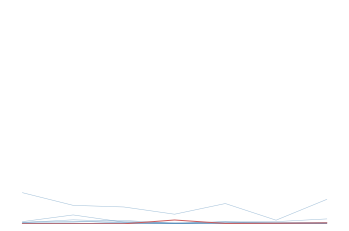

In [10]:
plot_time_series_with_centroid(x_train[:10, :, 0], x_train[11, :, 0], alpha=0.5)

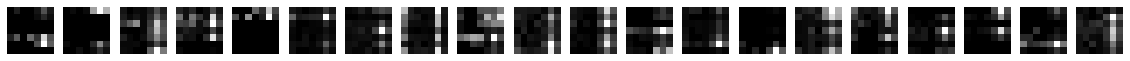

In [17]:
n_ts = 20
_, ax = plt.subplots(1, n_ts, figsize=(20, 4))
for i, s in enumerate(x_train[:n_ts]):
    ax[i].imshow(s, cmap='gray')
    ax[i].set_axis_off()
plt.show()

## Clustering with dynamic time warping

In [20]:
dtw_kmeans = TimeSeriesKMeans(
    n_clusters=15, 
    metric='dtw',
    max_iter=10,
    n_jobs=-1,
    verbose=False)

In [26]:
%%time
sample_idx = np.random.choice(len(x_train), 2000)
x_train_sample = x_train[sample_idx]
dtw_kmeans.fit(x_train_sample)

CPU times: user 663 µs, sys: 30 µs, total: 693 µs
Wall time: 271 µs


In [27]:
%time
train_clusters =  dtw_kmeans.predict(x_train_sample)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


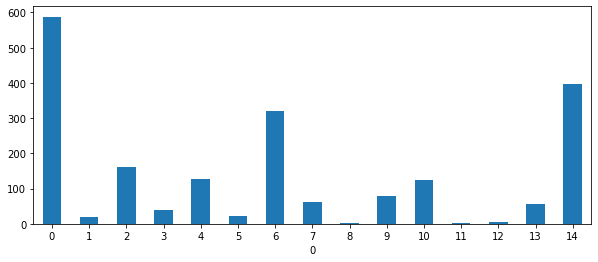

In [28]:
pd.DataFrame(train_clusters).groupby(0).size().plot(kind='bar', rot=0, figsize=(10, 4));

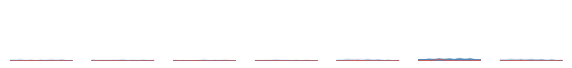

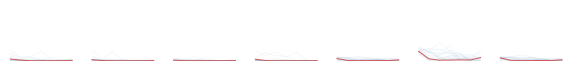

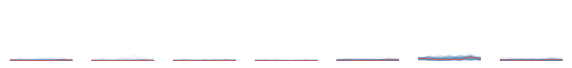

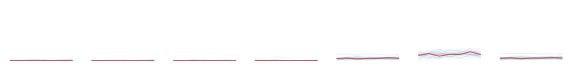

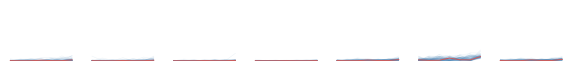

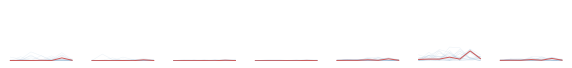

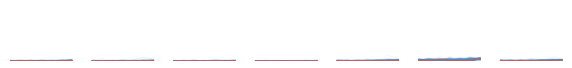

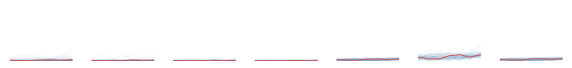

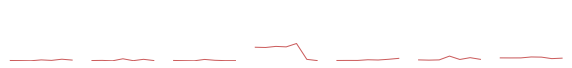

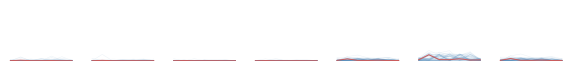

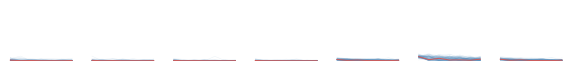

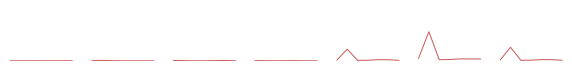

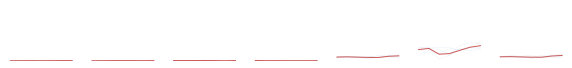

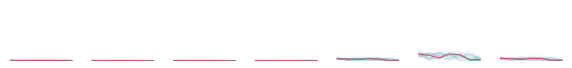

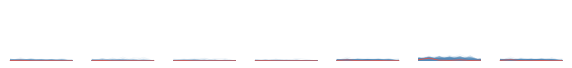

In [29]:
for i in range(dtw_kmeans.n_clusters):
    plot_time_series_all_features(x_train_sample[train_clusters == i], dtw_kmeans.cluster_centers_[i])

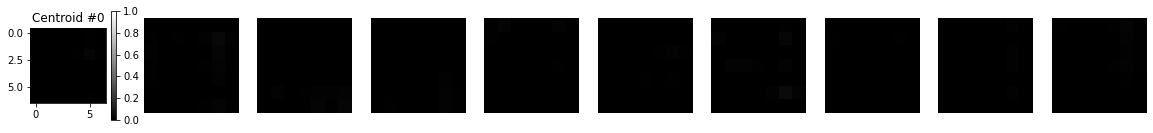

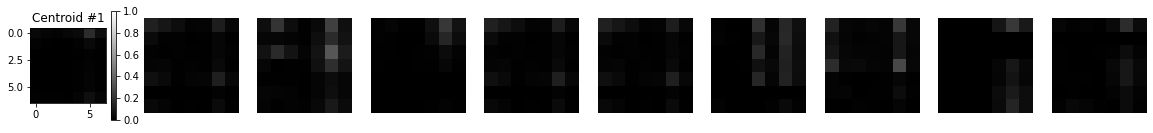

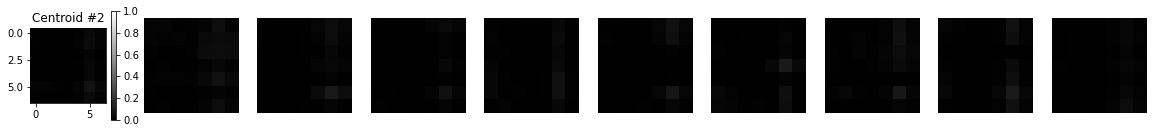

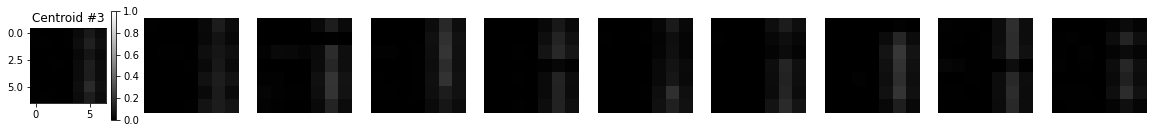

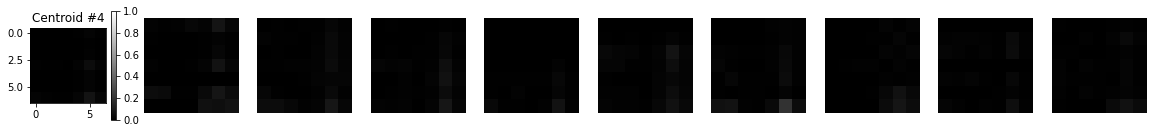

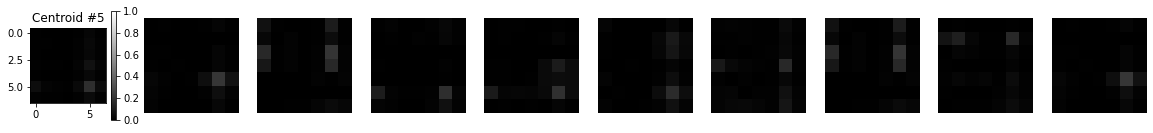

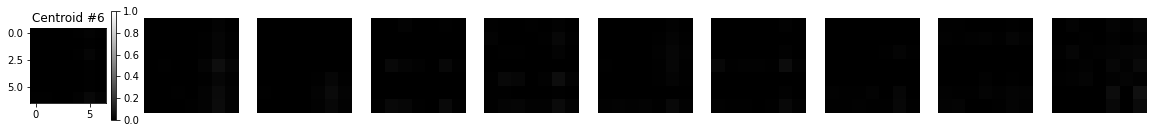

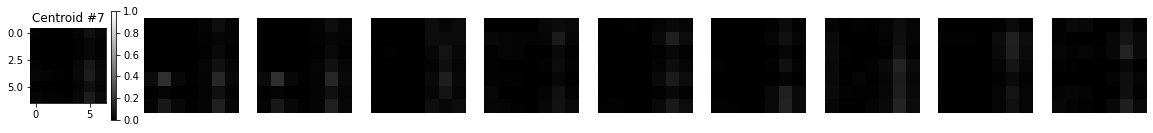

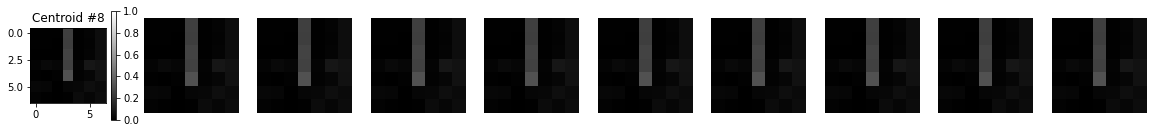

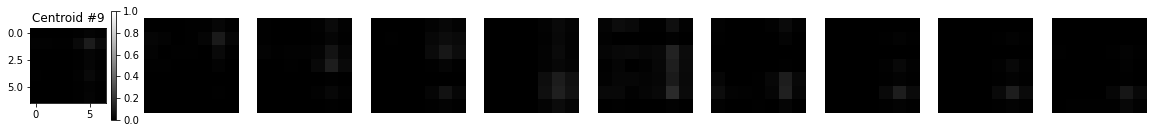

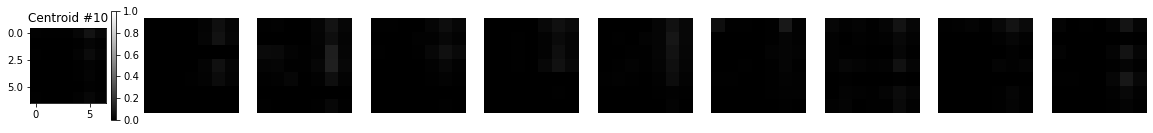

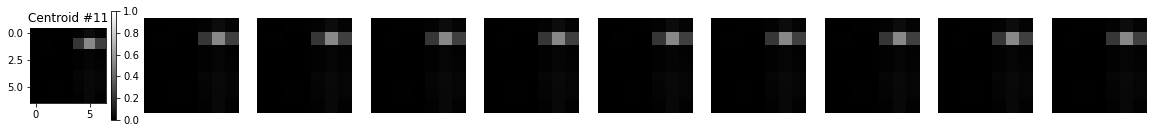

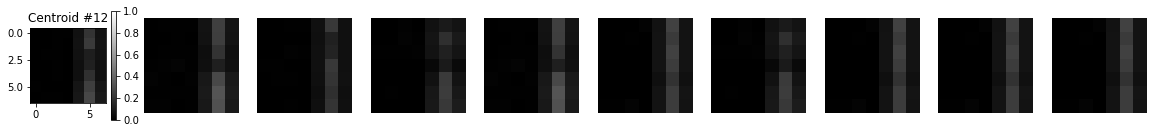

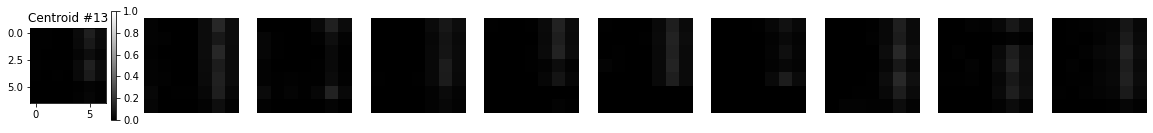

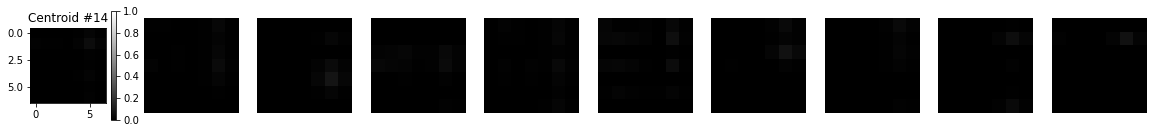

In [31]:
for i in range(dtw_kmeans.n_clusters):
    n_ts = 9
    fig, ax = plt.subplots(1, n_ts + 1, figsize=(20, 2))
    ax[0].set_title(f'Centroid #{i}')
    centroid_img = ax[0].imshow(dtw_kmeans.cluster_centers_[i], cmap='gray', vmin=0, vmax=1)
    x_in_cluster = x_train_sample[train_clusters == i]
    for i, s in enumerate(x_in_cluster[np.random.choice(len(x_in_cluster), n_ts)]):
        ax[i + 1].imshow(s, cmap='gray', vmin=0, vmax=1)
        ax[i + 1].set_axis_off()
    plt.colorbar(centroid_img, ax=ax[0])
    plt.show()

## Define the autoencoder

In [24]:
latent_shape = 5
learning_rate = 0.01
sequence_length = 7

prior = tfd.MultivariateNormalDiag(loc=tf.zeros(latent_shape))

kl_div_regularizer = tfpl.KLDivergenceRegularizer(
    prior,
    use_exact_kl=True)

activation = tfkl.LeakyReLU()

encoder = tfk.Sequential([
    tfkl.Input((sequence_length, 7)),
    tfkl.Conv1D(32, 3, strides=2, padding='SAME', activation=activation),
    tfkl.BatchNormalization(),
    tfkl.Conv1D(64, 3, strides=2, padding='SAME', activation=activation),
    tfkl.BatchNormalization(),
    tfkl.Flatten(),
    tfkl.Dense(latent_shape)
#     tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_shape)),
#     tfpl.MultivariateNormalTriL(
#         latent_shape,
#         activity_regularizer=kl_div_regularizer)
], name='encoder')

decoder = tfk.Sequential([
    tfkl.Dense(256, activation='relu', input_shape=(latent_shape,)),
    tfkl.Reshape((2, 1, 128)),
    tfkl.BatchNormalization(),
    tfkl.Conv2DTranspose(32, (3, 1), strides=(2, 1), activation=activation, padding='SAME'),
    tfkl.BatchNormalization(),
    tfkl.Conv2DTranspose(7, (3, 1), strides=(2, 1), activation=activation, padding='SAME'),
    tfkl.Cropping2D(((0, 1), (0, 0))),
    tfkl.Flatten(),
    tfpl.IndependentBernoulli((sequence_length, 7))
], name='decoder')

# encoder = tfk.Sequential([
#     tfkl.Bidirectional(tfkl.LSTM(10, activation='relu', return_sequences=True), input_shape=(sequence_length, 7)),
#     tfkl.Bidirectional(tfkl.LSTM(10, activation='relu', return_sequences=True)),
#     tfkl.Bidirectional(tfkl.LSTM(10, activation='relu'))
# ])

# decoder = tfk.Sequential([
#     tfkl.RepeatVector(sequence_length, input_shape=(20, )),
#     tfkl.Bidirectional(tfkl.LSTM(10, activation='relu', return_sequences=True)),
#     tfkl.LSTM(7, activation='sigmoid', return_sequences=True)
# ])

print(encoder.summary())
print(decoder.summary())

def rel_mae(y_true, y_pred, epsilon=10e-5):
    return tf.reduce_mean(tf.where(y_true < epsilon, 0.0, tf.abs(y_true - y_pred) / tf.abs(y_true)))

def nll(x, dist):
    return - tf.reduce_mean(dist.log_prob(x))

autoencoder = tfk.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer=tfk.optimizers.Adam(learning_rate=learning_rate), loss=nll, metrics=[rel_mae])

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4, 32)             704       
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 32)             128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 64)             6208      
_________________________________________________________________
batch_normalization_5 (Batch (None, 2, 64)             256       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 7,941
Trainable params: 7,749
Non-trainable params: 192
_______________________________________________________

In [25]:
%%time
rl_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=1
)

history = autoencoder.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[rl_scheduler],
    verbose=1)

Train for 11346 steps, validate for 3782 steps
Epoch 1/10
11346/11346 [==============================] - 59s 5ms/step - loss: 0.7101 - rel_mae: 2.1763 - val_loss: 0.6711 - val_rel_mae: 1.9703
Epoch 2/10
11346/11346 [==============================] - 55s 5ms/step - loss: 0.6283 - rel_mae: 1.2462 - val_loss: 0.6338 - val_rel_mae: 1.3856
Epoch 3/10
11346/11346 [==============================] - 55s 5ms/step - loss: 0.6270 - rel_mae: 1.2404 - val_loss: 3.2904 - val_rel_mae: 0.6899
Epoch 4/10
11346/11346 [==============================] - 59s 5ms/step - loss: 0.6262 - rel_mae: 1.2359 - val_loss: 0.6498 - val_rel_mae: 1.0690
Epoch 5/10
11346/11346 [==============================] - 57s 5ms/step - loss: 0.6260 - rel_mae: 1.2242 - val_loss: 0.6332 - val_rel_mae: 1.1989
Epoch 6/10
11346/11346 [==============================] - 56s 5ms/step - loss: 0.6256 - rel_mae: 1.2255 - val_loss: 0.6505 - val_rel_mae: 1.1764
Epoch 7/10
11346/11346 [==============================] - 52s 5ms/step - loss: 0.62

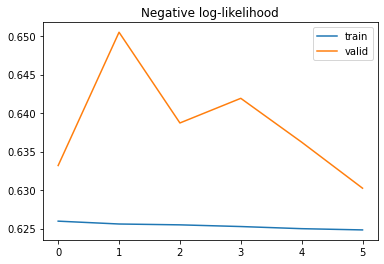

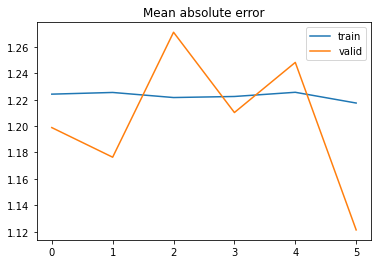

In [29]:
start_after_drop = 4

plt.title('Negative log-likelihood')
plt.plot(history.history['loss'][start_after_drop:], label='train')
plt.plot(history.history['val_loss'][start_after_drop:], label='valid')
plt.legend()
plt.show()
plt.title('Mean absolute error')
plt.plot(history.history['rel_mae'][start_after_drop:], label='train')
plt.plot(history.history['val_rel_mae'][start_after_drop:], label='valid')
plt.legend()
plt.show()

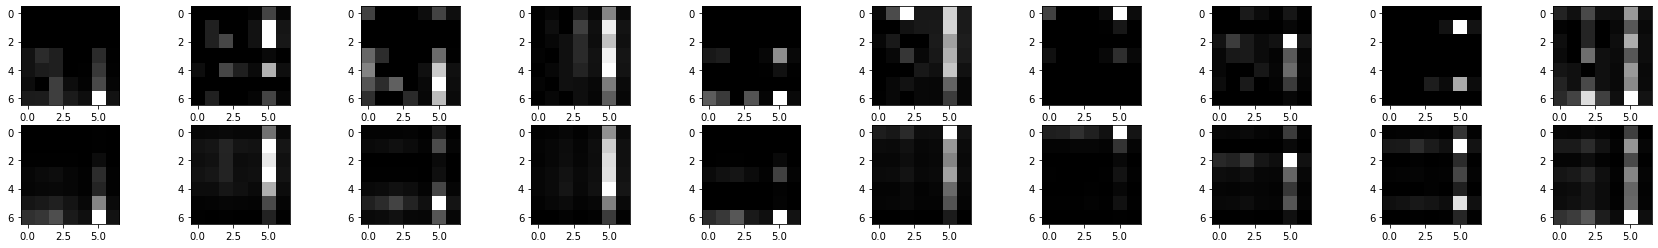

In [30]:
idxs = np.random.choice(len(weekly_ts), 10)
samples = weekly_ts[idxs]
samples_rec = autoencoder(samples).mean().numpy()

_, ax = plt.subplots(2, len(idxs), figsize=(30, 4))
for i, idx in enumerate(idxs):
    ax[0][i].imshow(samples[i], cmap='gray')
    ax[1][i].imshow(samples_rec[i], cmap='gray')
plt.show()

In [37]:
len(logs_per_user)

655809

In [ ]:
latent_values = encoder(x_train).numpy()

In [51]:
%%time
mixture = GaussianMixture(n_components=100)
mixture.fit(latent_values)

CPU times: user 8min 2s, sys: 9.63 s, total: 8min 12s
Wall time: 1min 31s


GaussianMixture(n_components=100)

In [52]:
%%time
tsne = TSNE()
planar_values = tsne.fit_transform(np.vstack([latent_values[np.random.choice(len(latent_values), 2000)], mixture.means_]))

CPU times: user 48 s, sys: 673 ms, total: 48.7 s
Wall time: 4.2 s


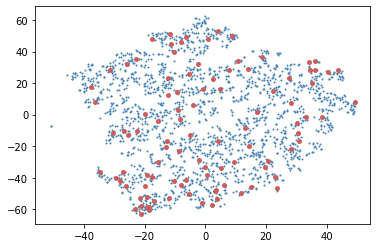

In [53]:
plt.scatter(*planar_values.T, s=1, color='steelblue')
plt.scatter(*planar_values[-len(mixture.means_):].T, color='indianred', s=15)
plt.show()

In [54]:
train_components = mixture.predict(latent_values)

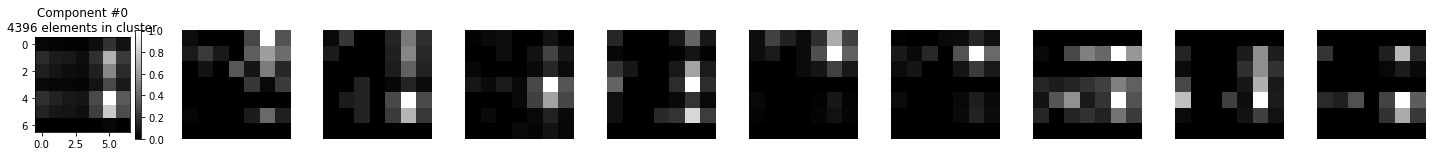

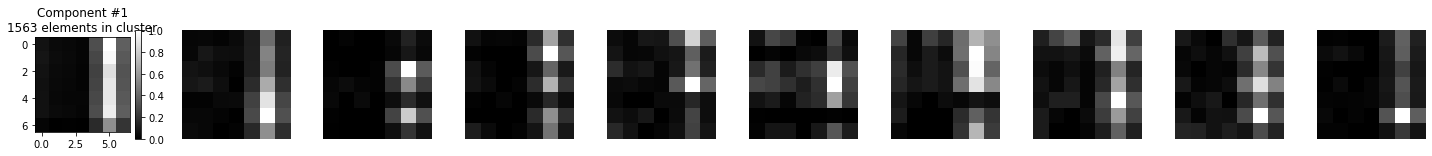

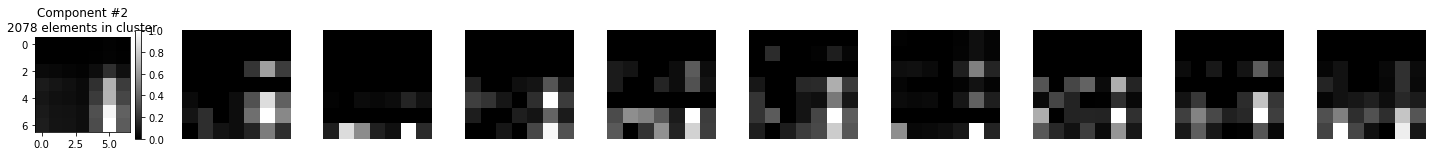

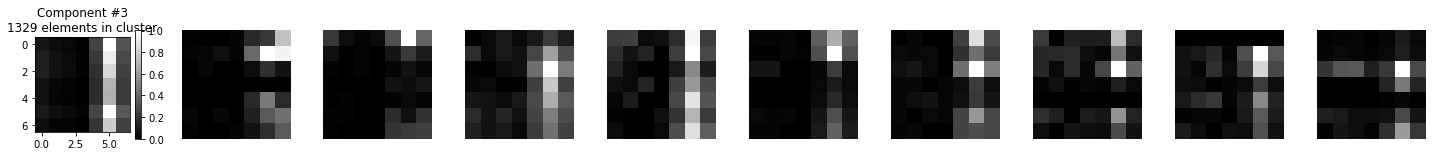

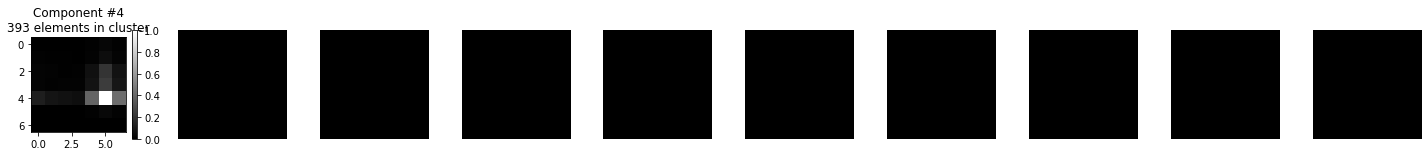

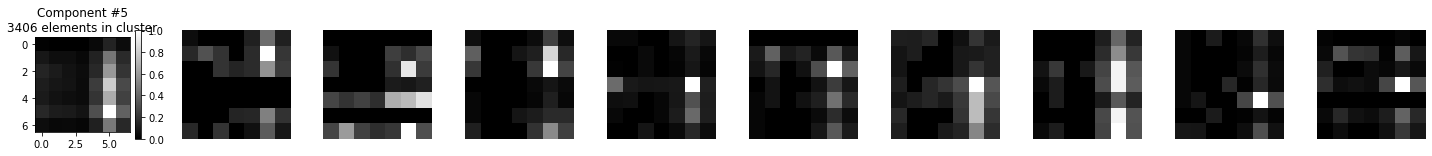

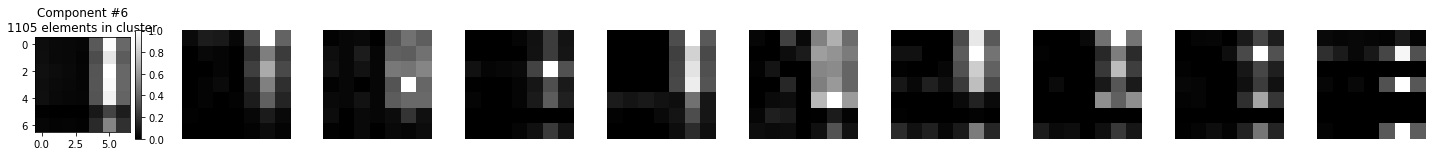

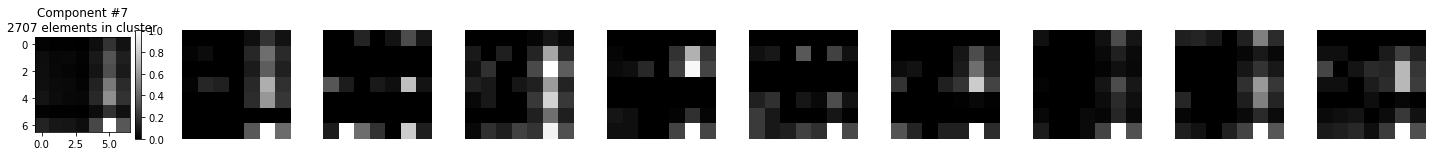

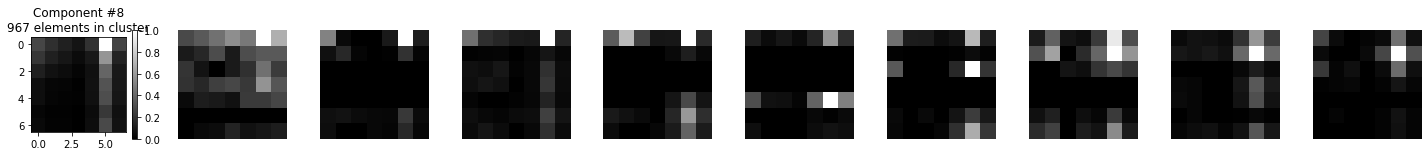

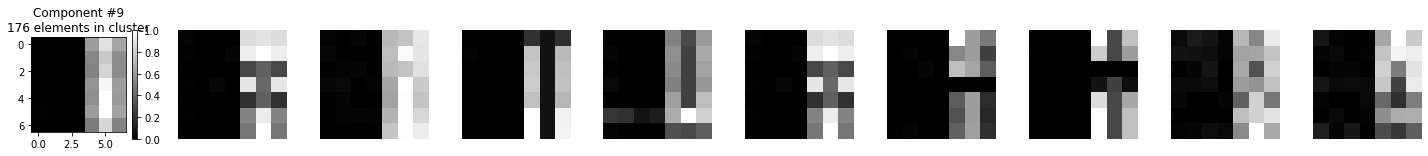

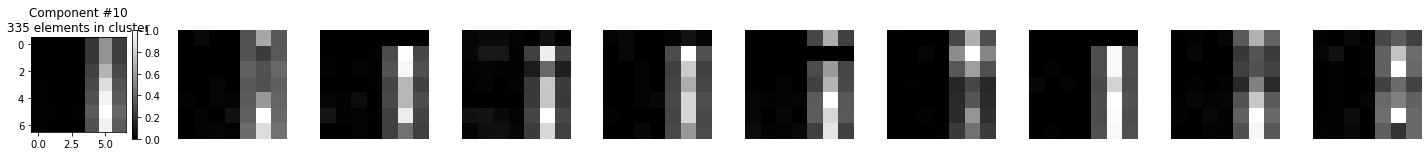

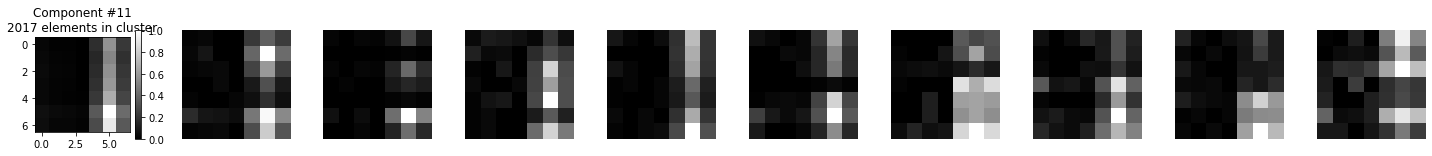

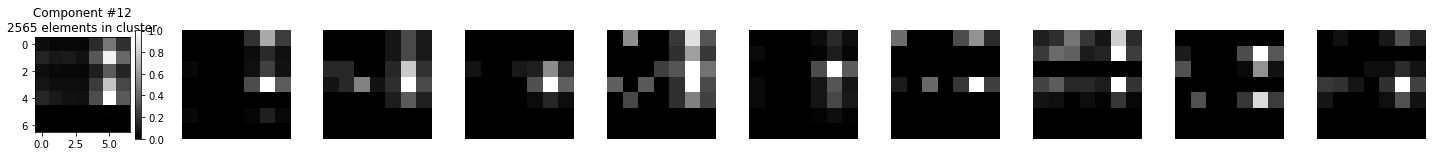

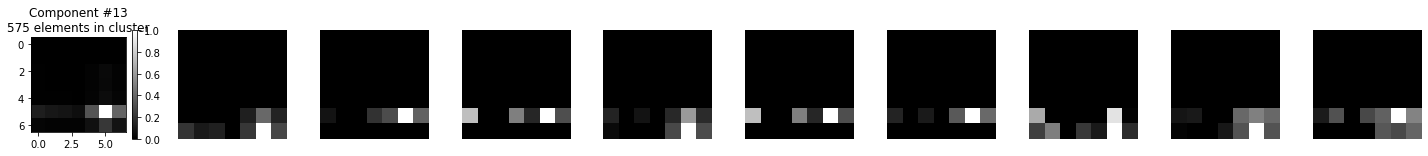

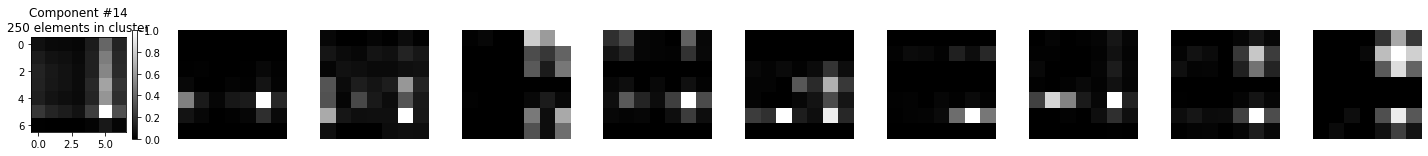

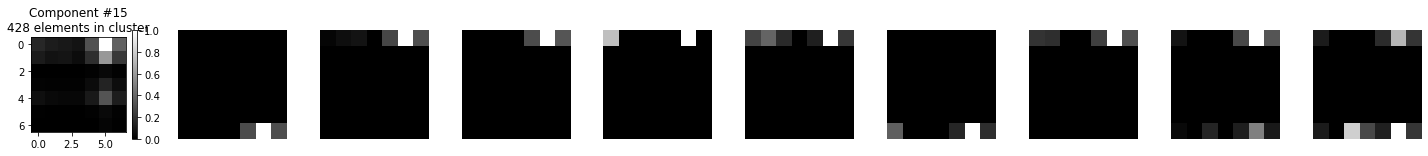

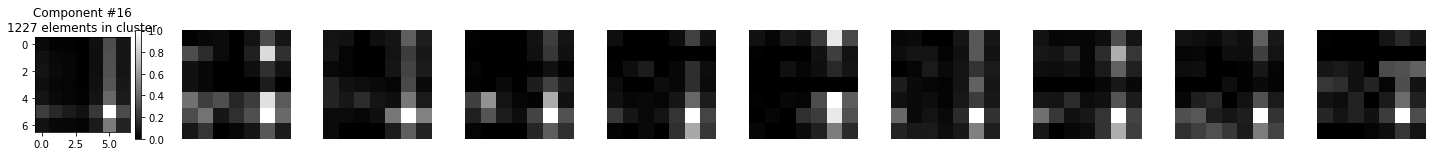

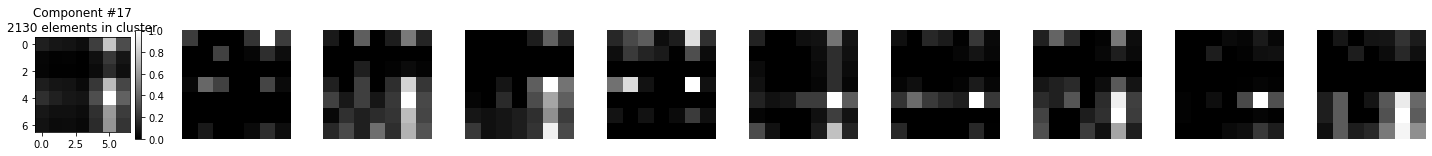

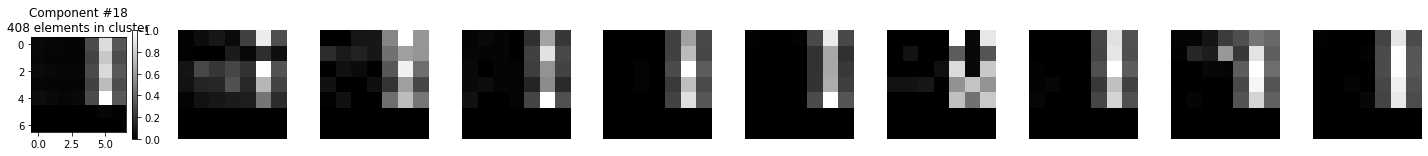

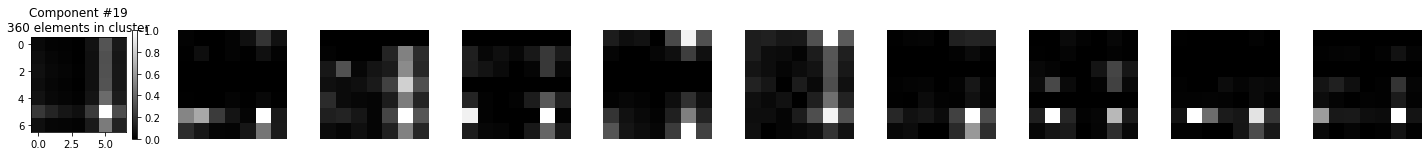

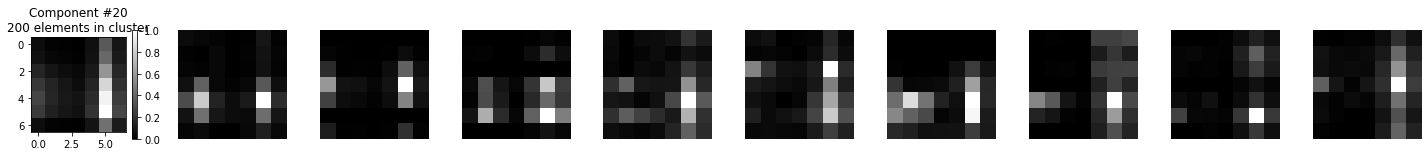

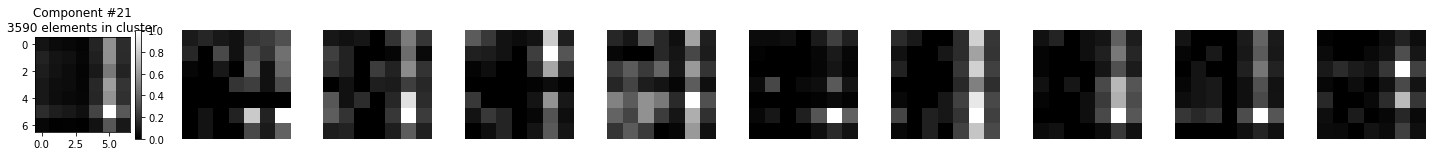

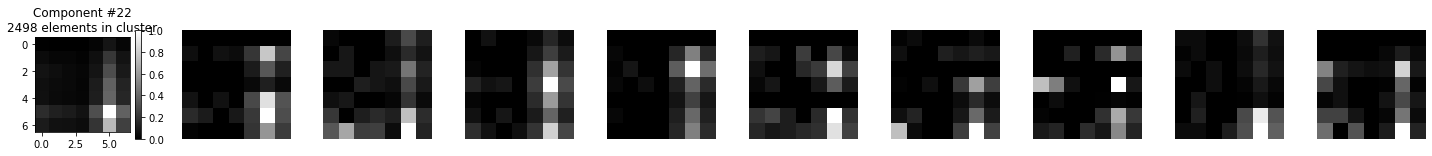

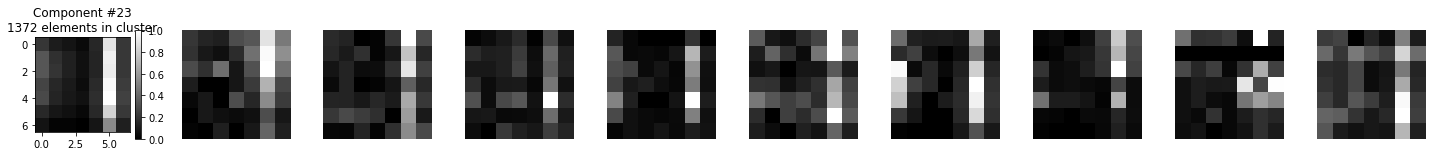

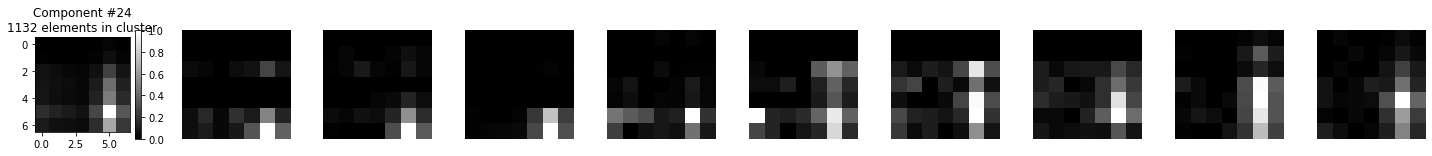

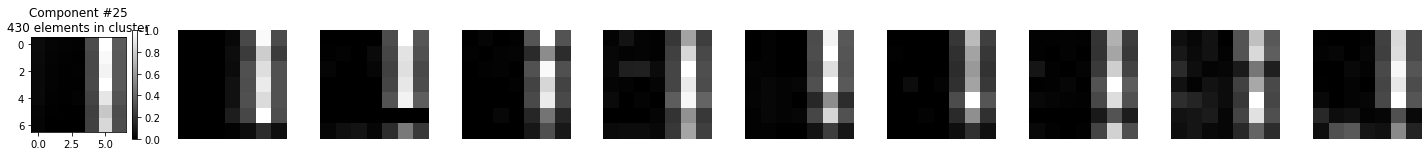

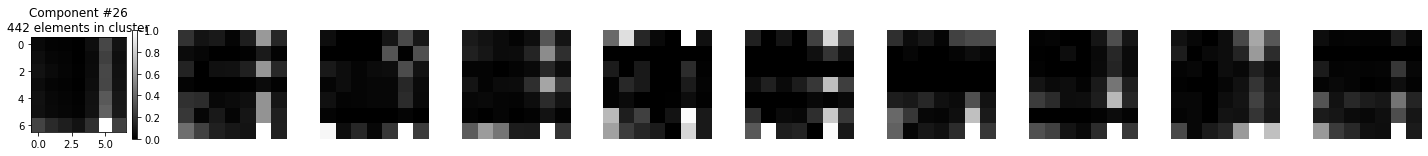

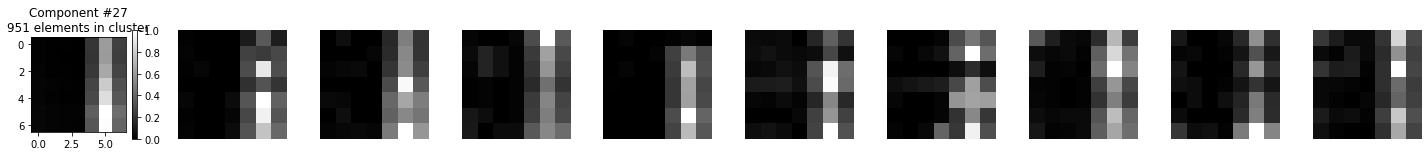

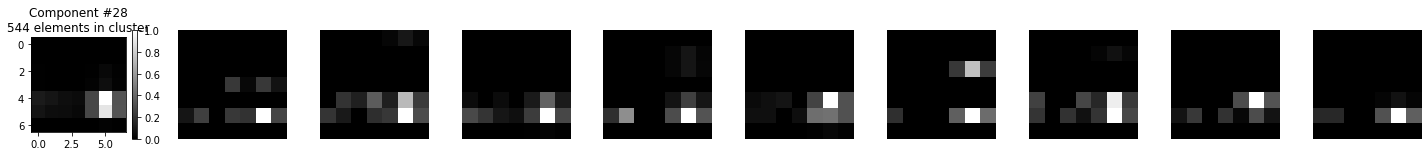

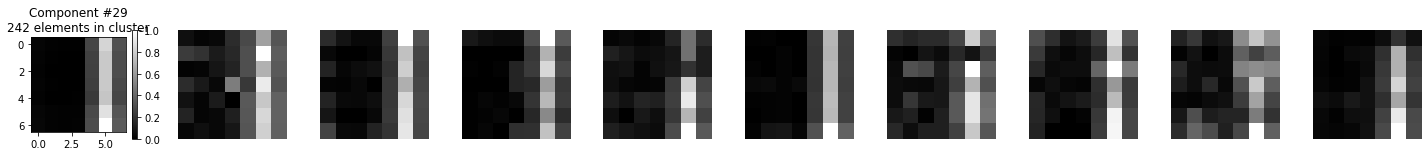

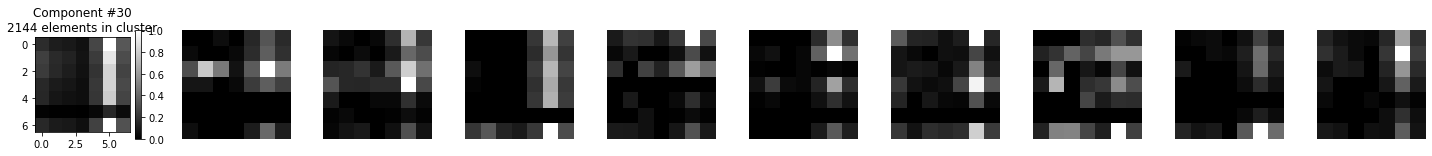

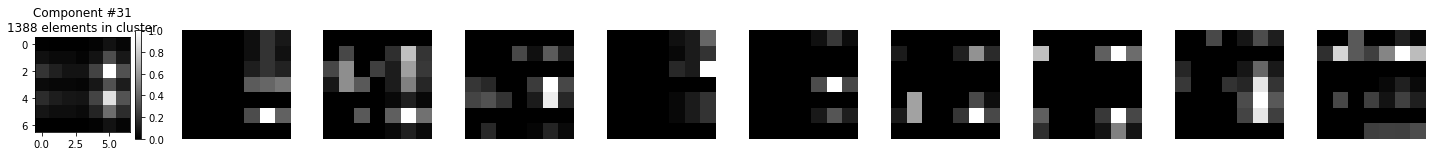

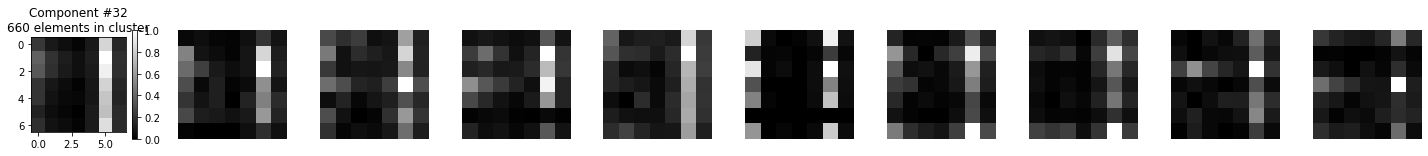

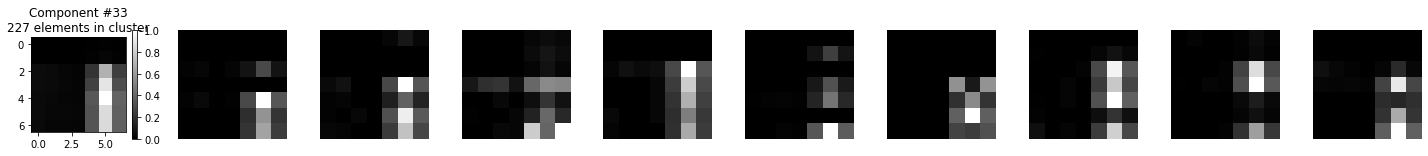

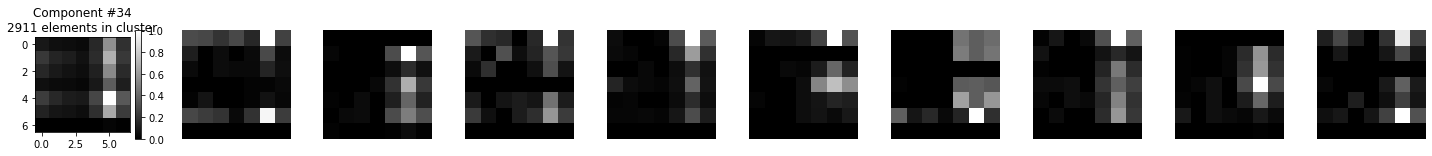

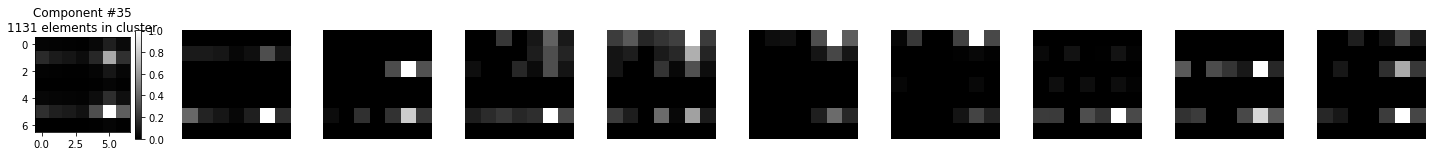

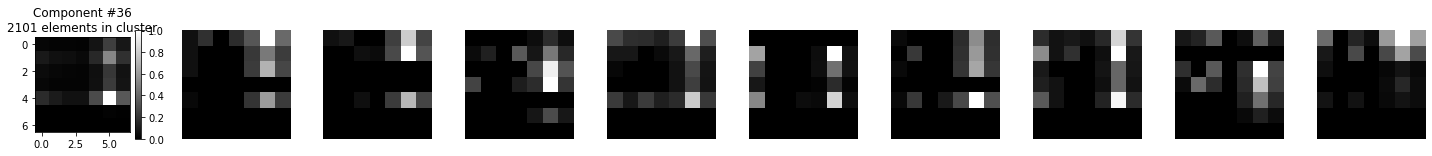

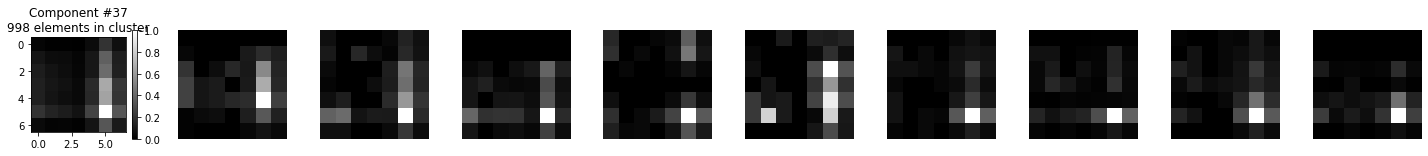

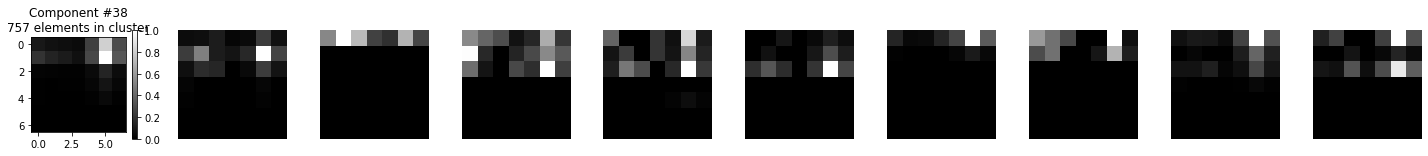

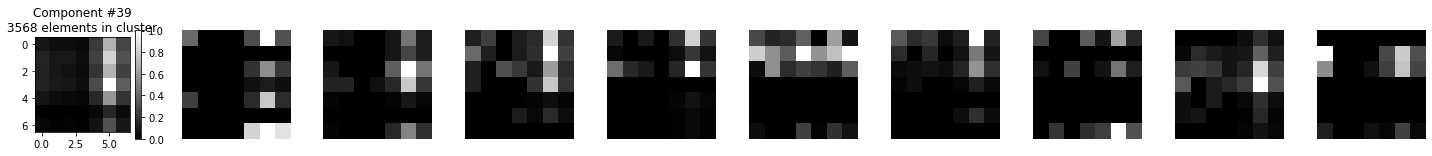

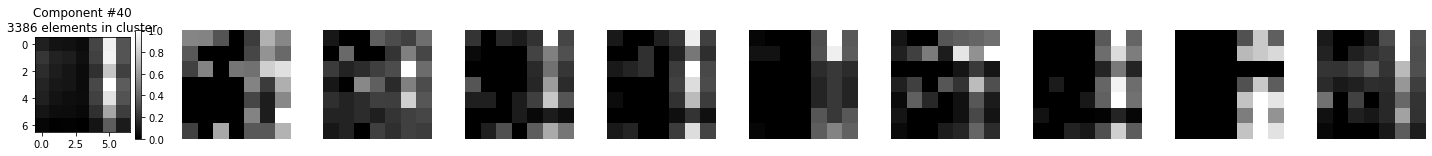

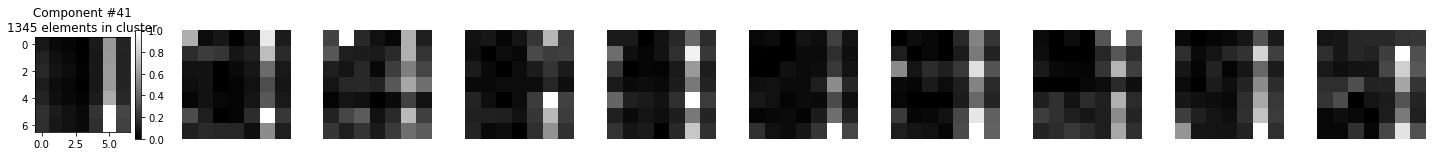

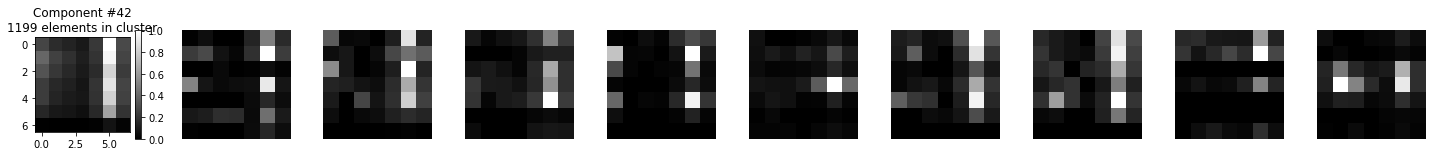

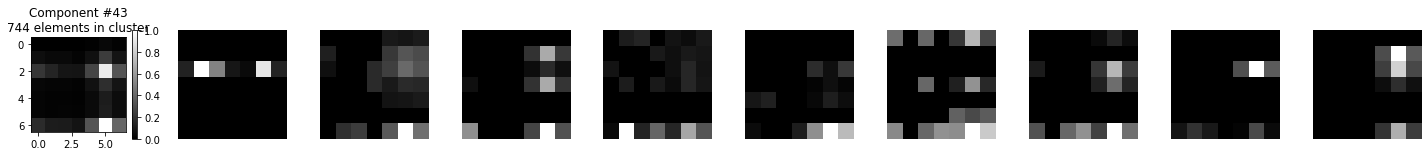

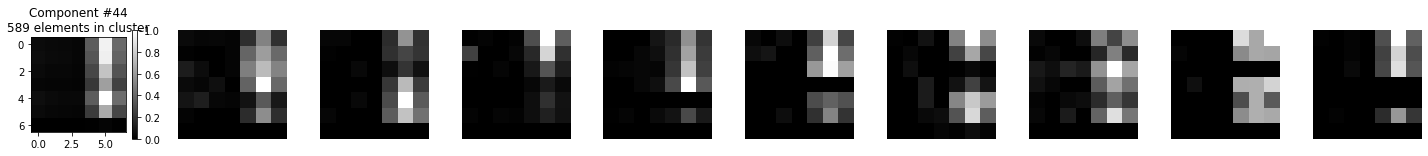

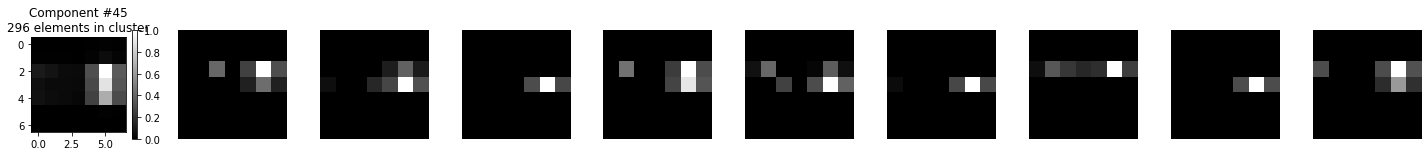

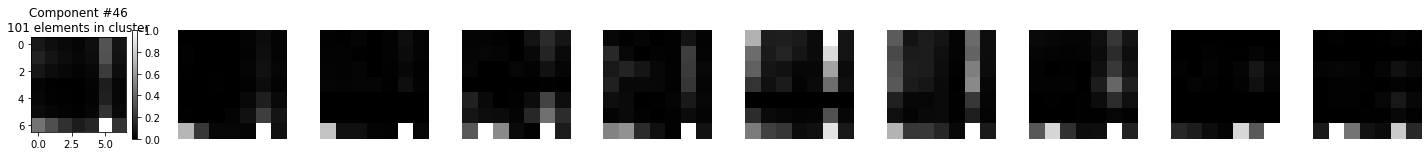

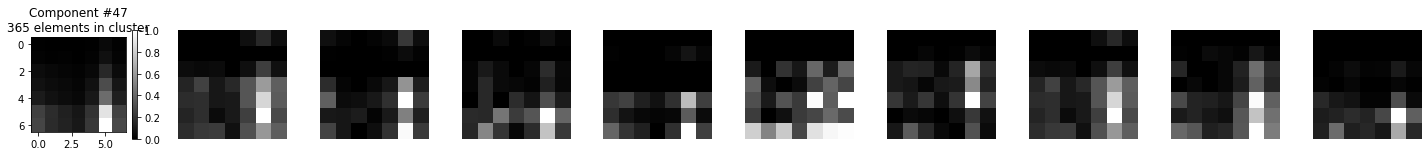

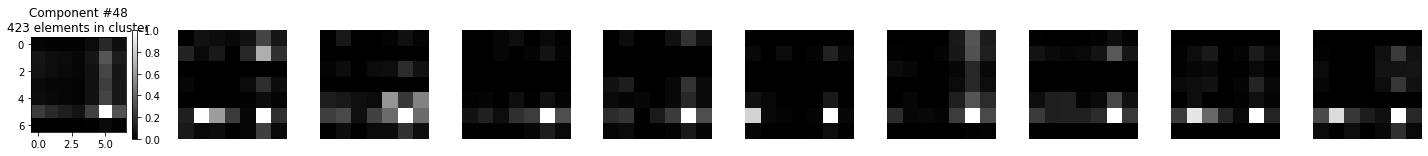

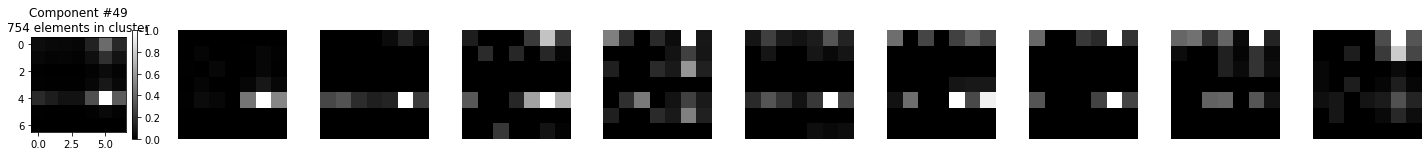

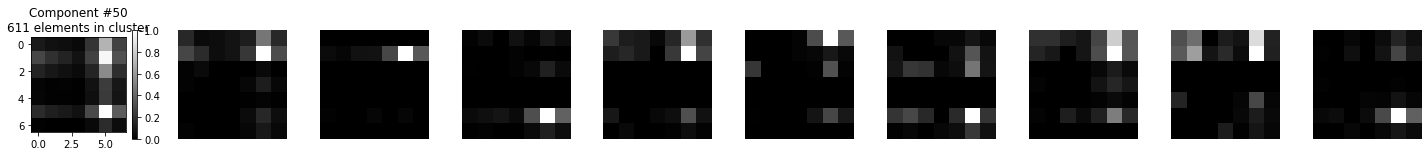

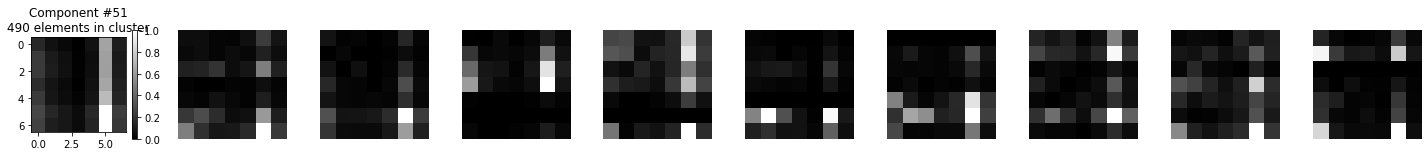

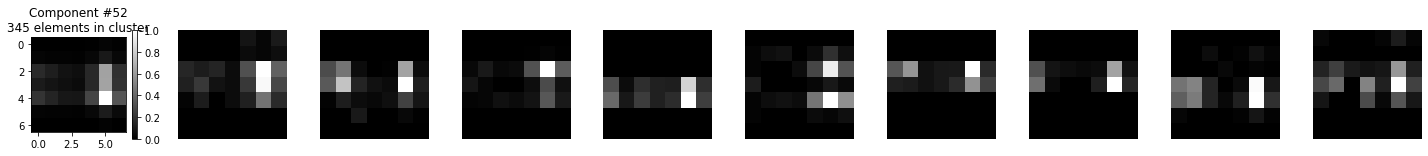

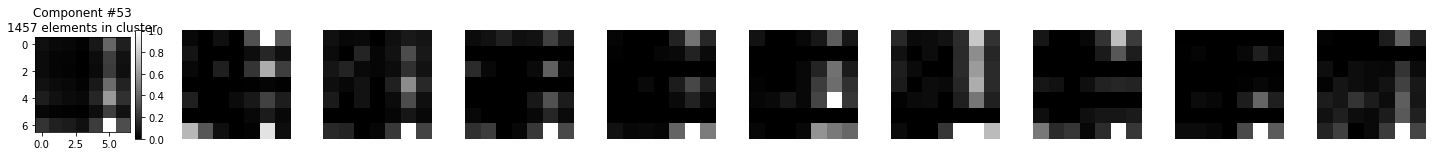

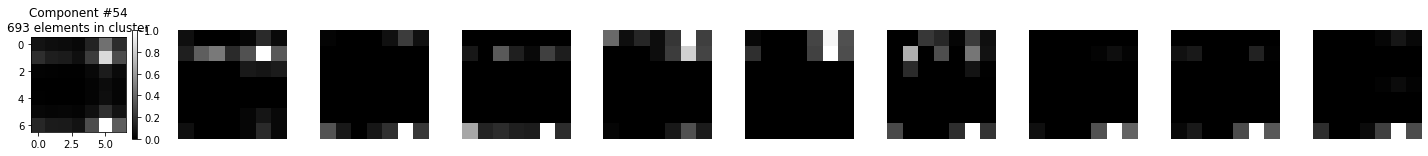

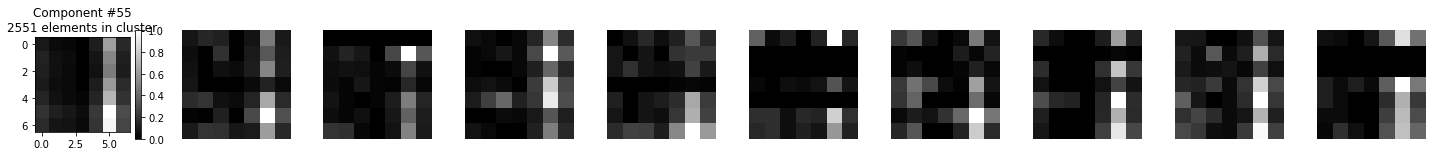

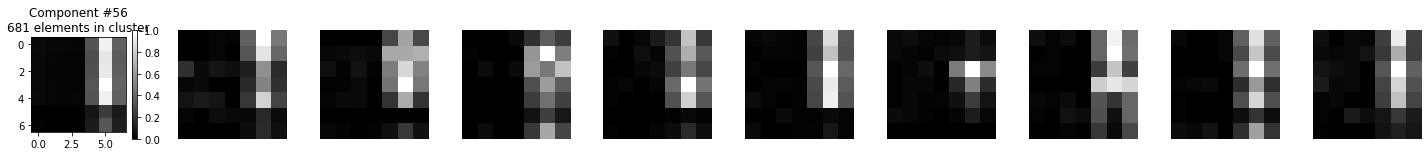

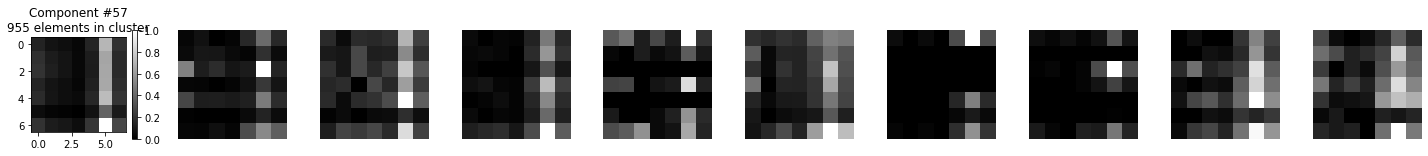

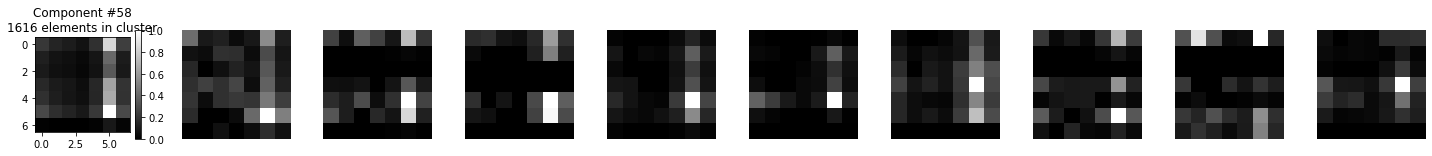

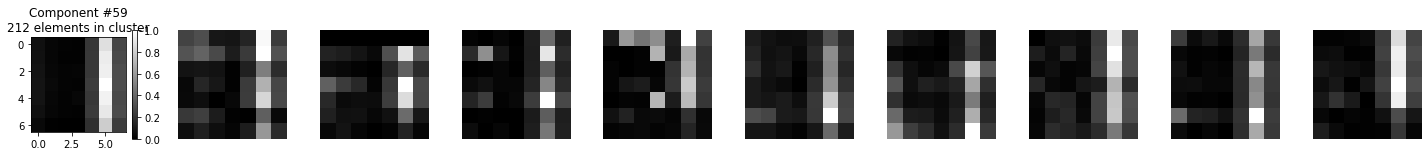

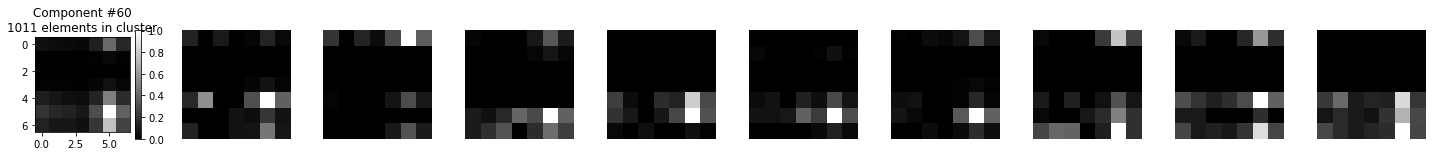

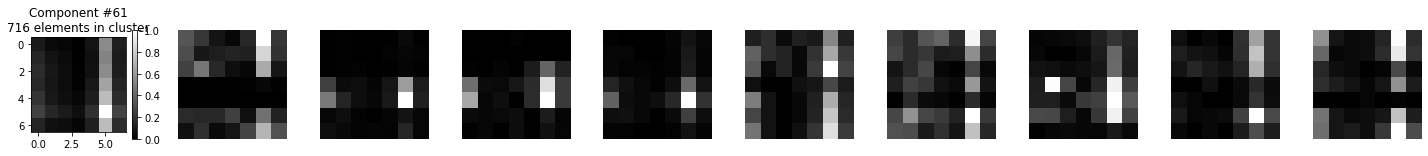

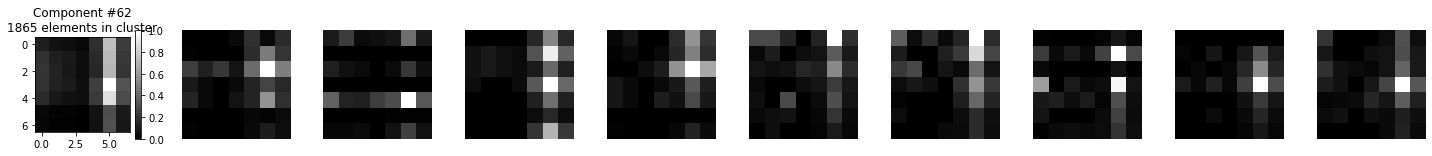

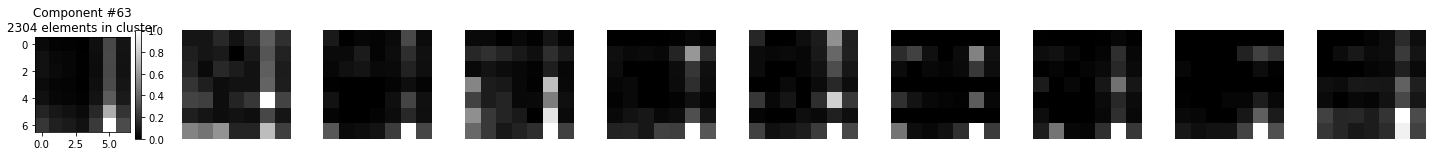

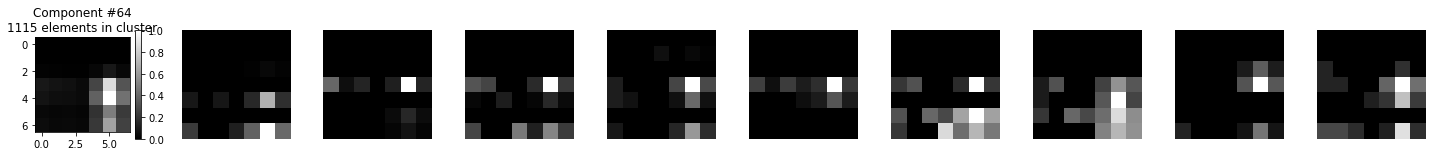

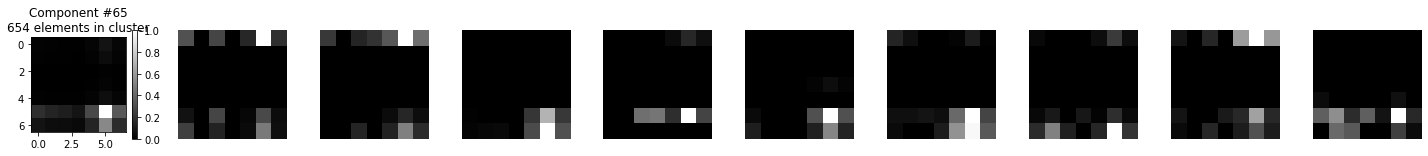

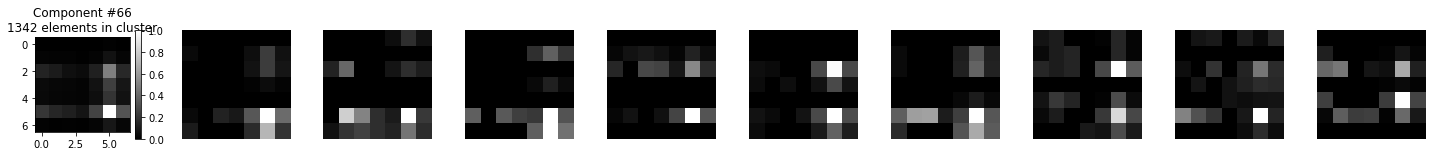

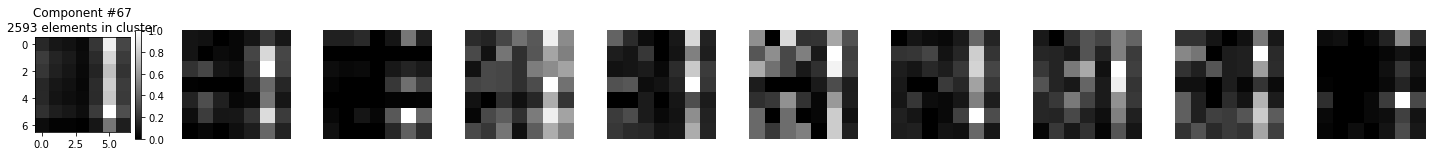

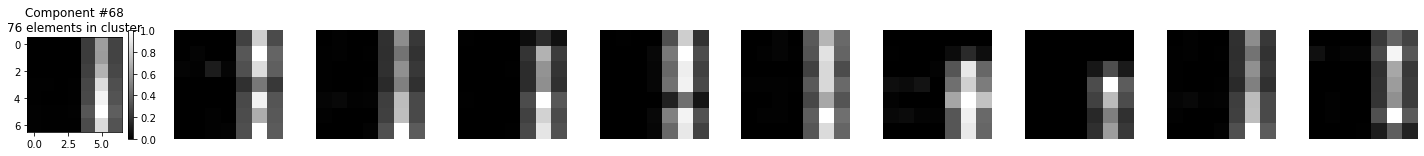

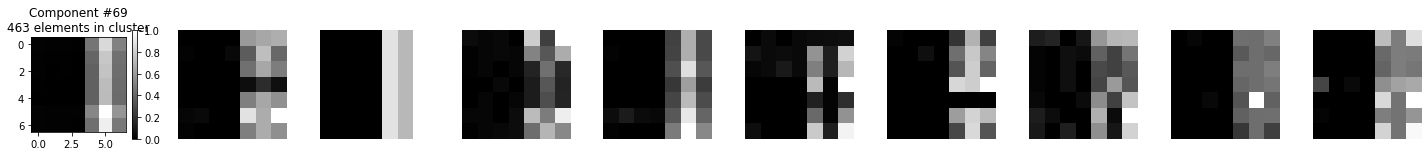

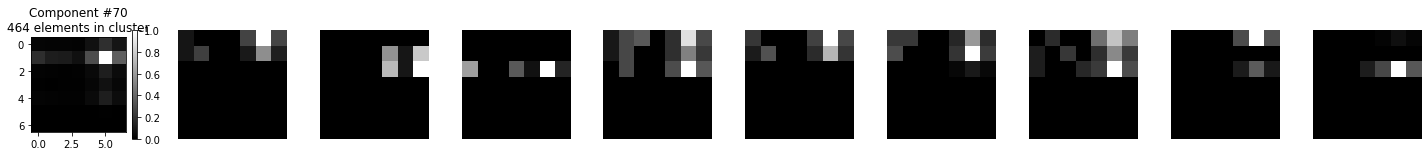

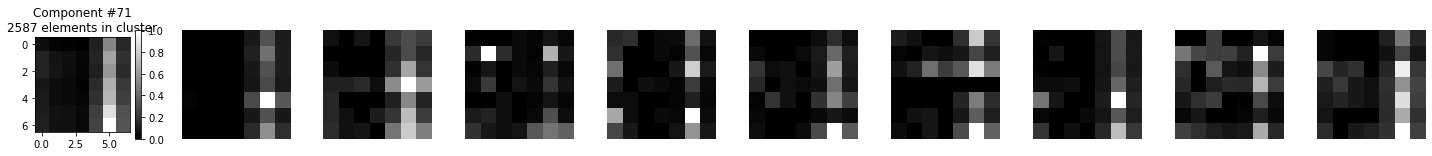

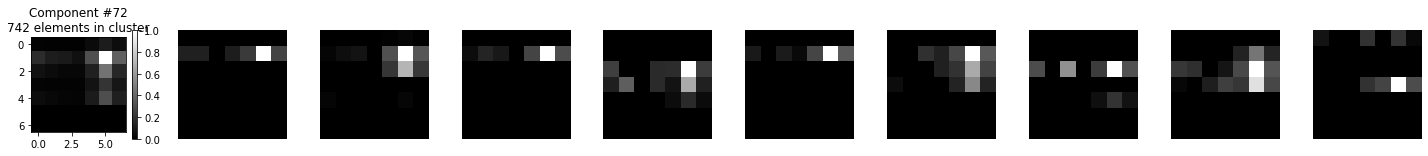

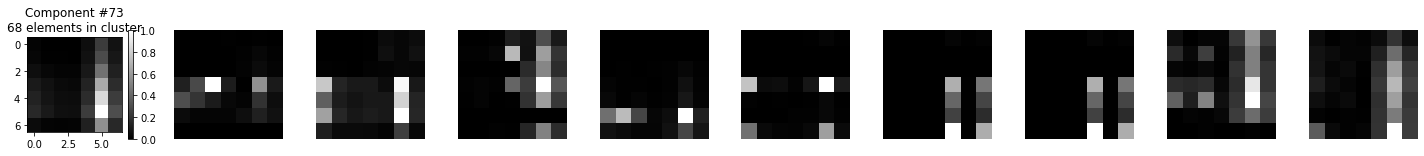

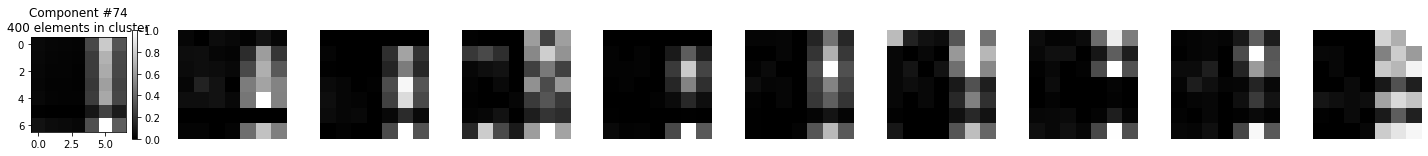

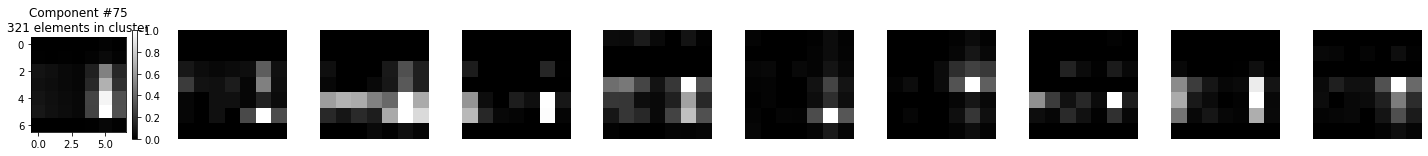

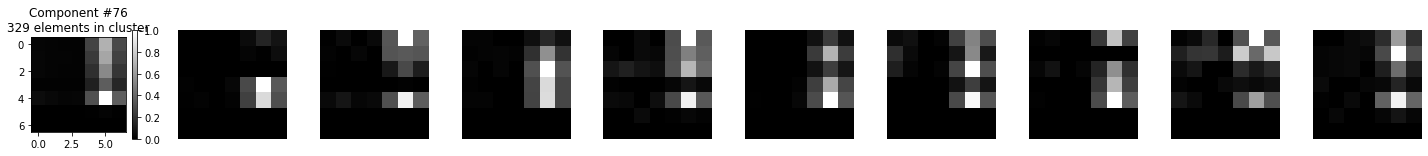

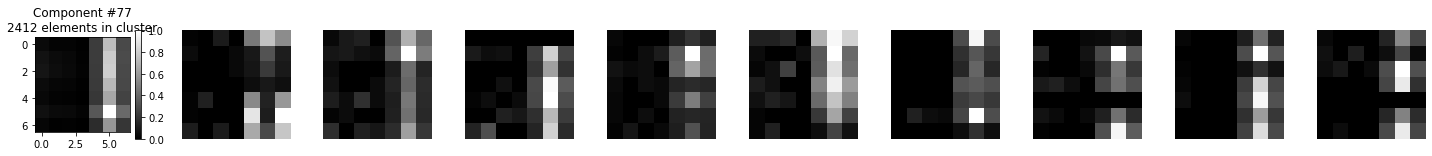

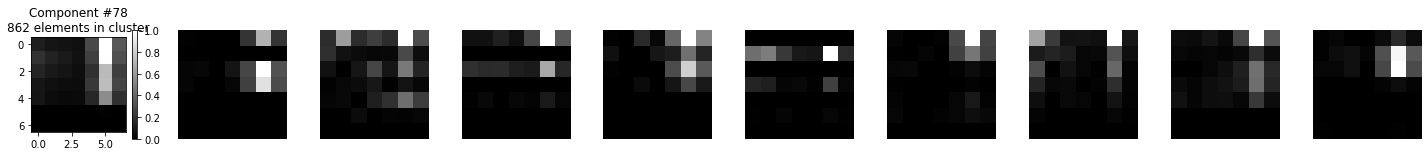

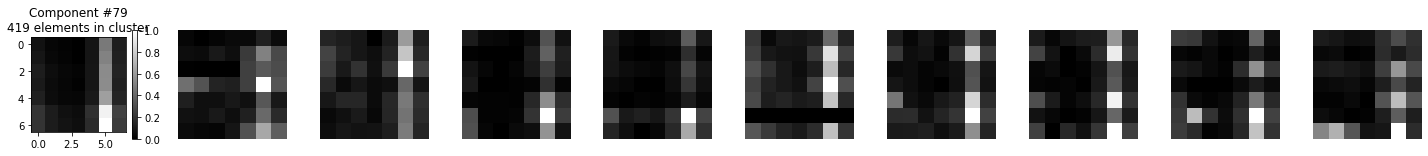

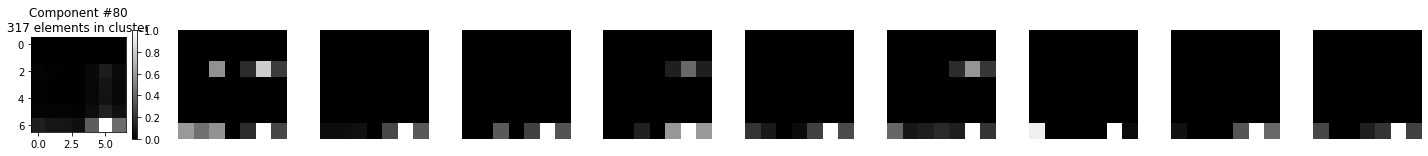

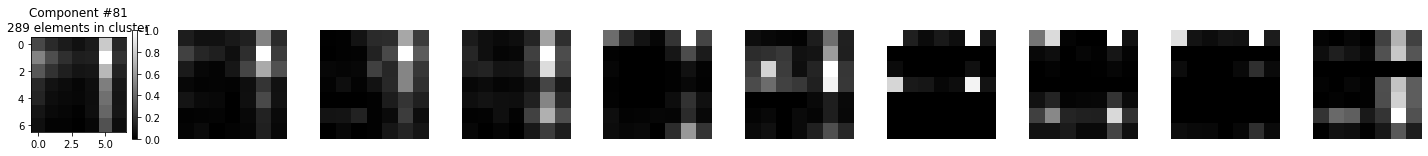

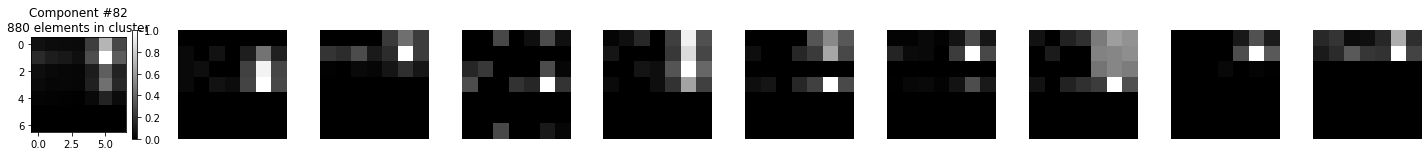

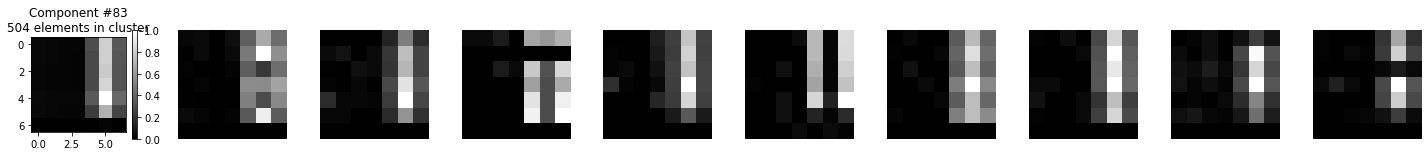

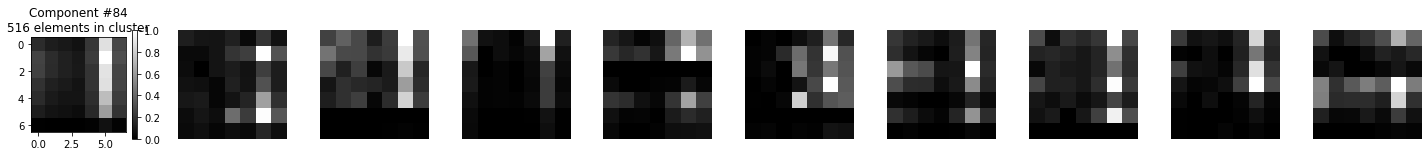

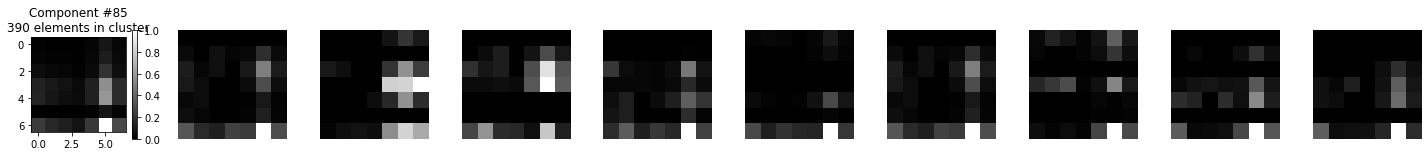

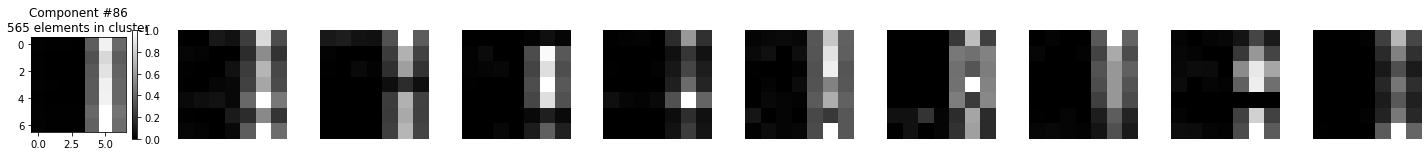

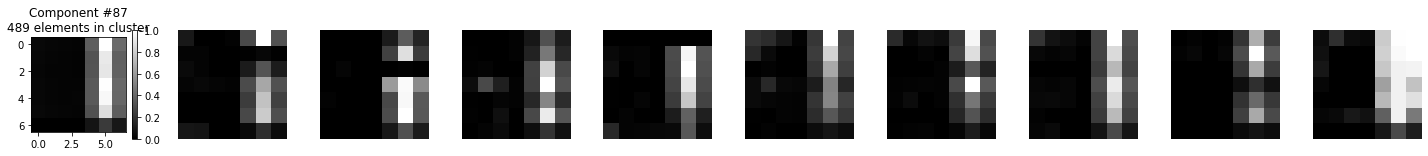

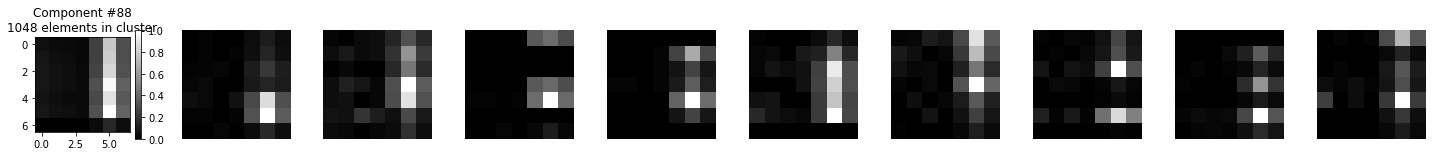

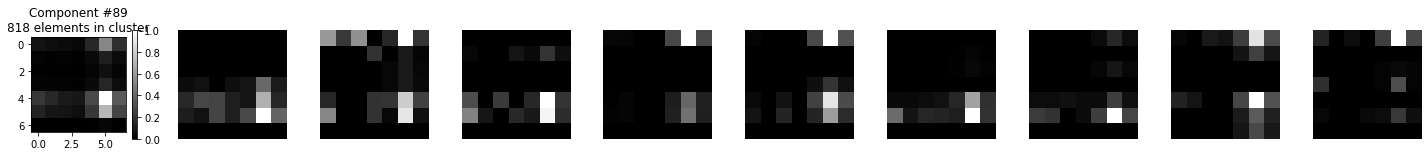

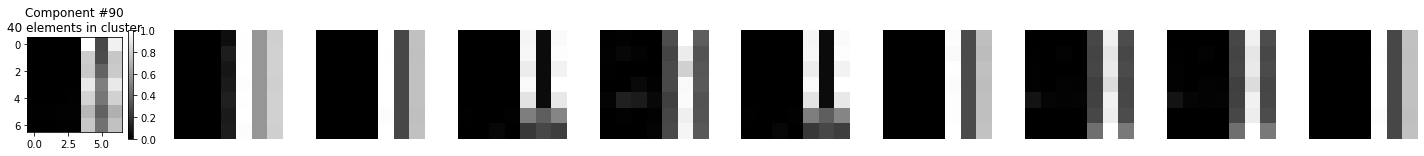

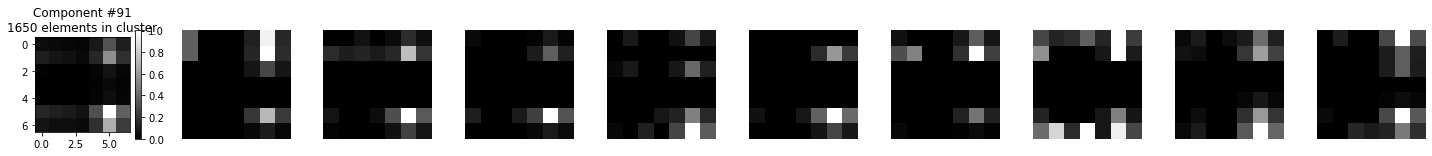

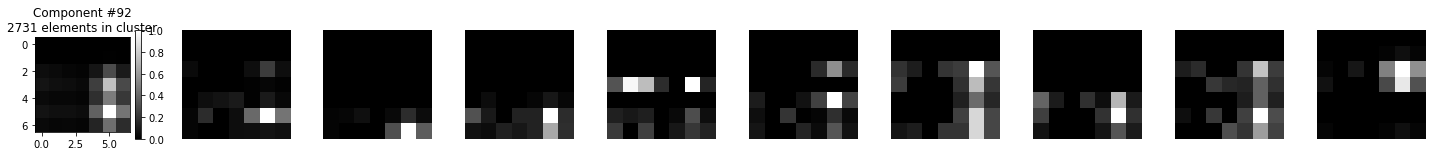

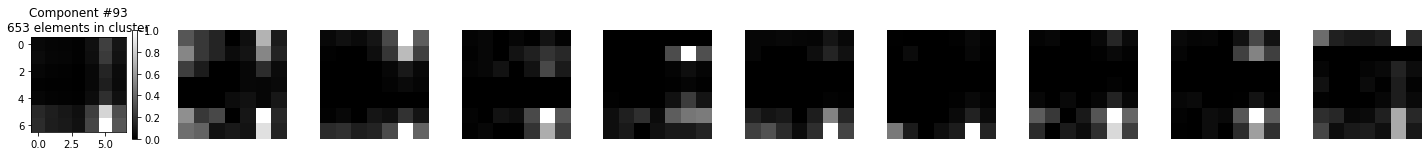

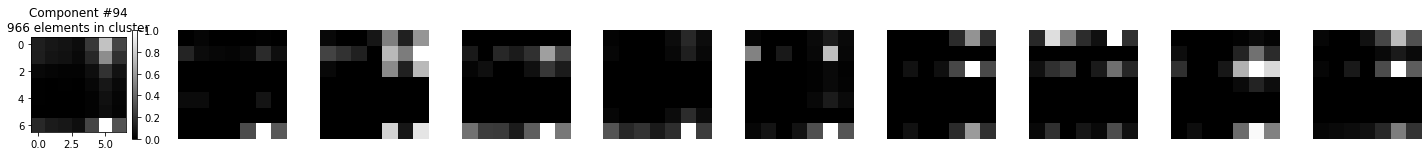

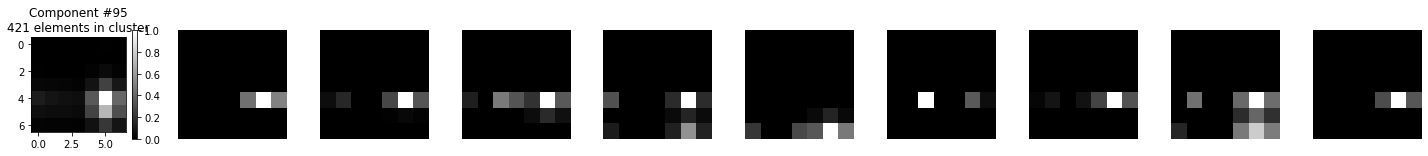

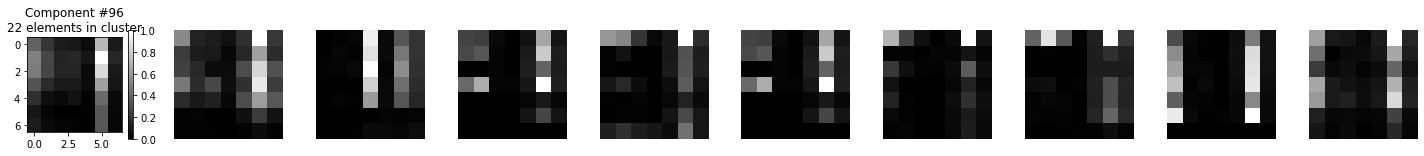

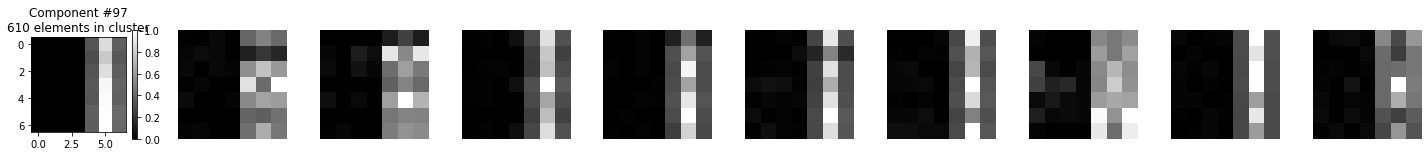

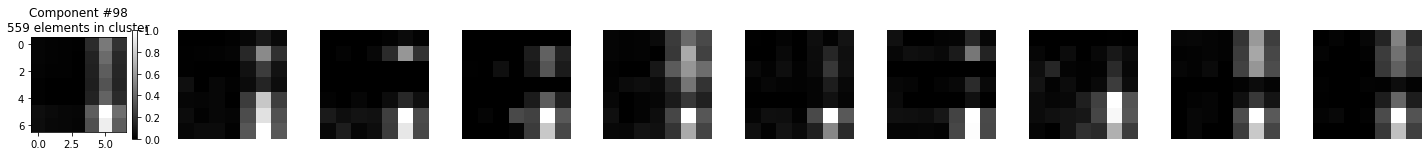

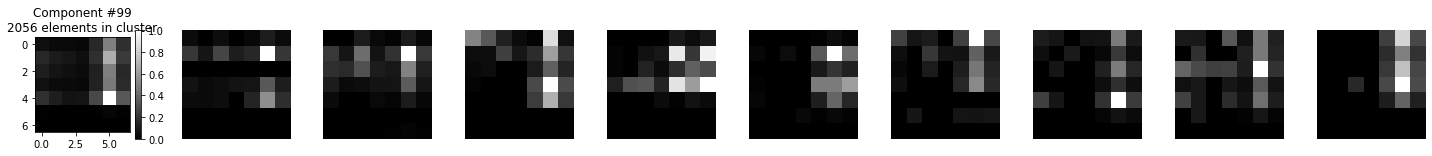

In [58]:
for i in range(mixture.n_components):
    n_ts = 9
    fig, ax = plt.subplots(1, n_ts + 1, figsize=(25, 2))
    x_in_cluster = x_train[train_components == i]
    ax[0].set_title(f'Component #{i}\n{len(x_in_cluster)} elements in cluster')
    component_center_img = ax[0].imshow(decoder(np.expand_dims(mixture.means_[i], axis=0)).mean()[0], cmap='gray')#, vmin=0, vmax=1)
    for i, s in enumerate(x_in_cluster[np.random.choice(len(x_in_cluster), n_ts)]):
        ax[i + 1].imshow(s, cmap='gray')#, vmin=0, vmax=1)
        ax[i + 1].set_axis_off()
    plt.colorbar(centroid_img, ax=ax[0])
    plt.show()

## Train and export the model

## Visualize the clusters distribution and some of the results